# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os 
from utils import augmentation, llm, gpt, images

import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, CLIPModel, CLIPProcessor

# Load Data

In [3]:
IMAGES = np.load('datasets/pixelarts_images.npy', allow_pickle=True)
LABELS = np.load('datasets/pixelarts_labels.npy', allow_pickle=True).tolist()

In [4]:
print(IMAGES.shape)
print(len(LABELS))

(300, 16, 16, 3)
300


In [5]:
LABELS[228]

'a red tomato with a green stem'

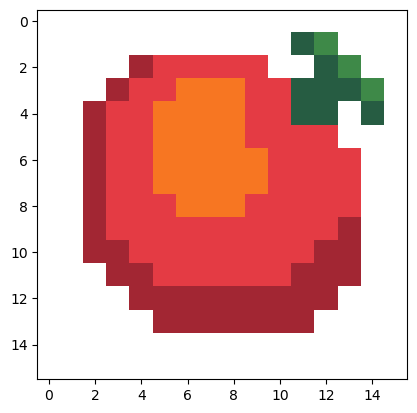

In [6]:
plt.imshow(IMAGES[228])

# Load Pretrained Models

In [7]:
# sentence embedding model
# https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# limit of 512 word pieces, trained on length of 250 word pieces and might not work for longer texts

tokenizer_uri_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
clip_uri_name = "openai/clip-vit-base-patch32"

LLM_TOKENIZER = AutoTokenizer.from_pretrained(tokenizer_uri_name)
LLM_MODEL = AutoModel.from_pretrained(tokenizer_uri_name)

CLIP_PROCESSOR = CLIPProcessor.from_pretrained(clip_uri_name)
CLIP_MODEL = CLIPModel.from_pretrained(clip_uri_name)

/Users/henrymei/anaconda3/envs/five-dollar-model/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/henrymei/anaconda3/envs/five-dollar-model/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Setup GPT

In [8]:
with open('apikey.env', 'r') as file:
    # Read the content of the file
    api_key = file.read().strip() 

In [9]:
client = OpenAI(api_key=api_key)

In [19]:
GPT_PROMPT = """
    Each string in the list provided is a description of a pixel art image. For each string, write a corresponding alternate description that uses different words, sentence structure, and length. Use common words when writing the alternate labels and do not simply correct spelling and punctuation or use a different regional spelling (e.g., gray versus grey). Each alternate description should be different from the original string in a significant way. Your output list should have the same number of strings as the input list. """

GPT_ROLE = """
    You are a helpful assistant with excellent attention to detail. You only output python lists of strings according 
    to the instructions you are given. Output the list on a single line, without any newlines. Make sure every list is 
    closed properly. Each output string is significantly different than the input."
    """

GPT_TOKEN_THRESHOLD = 4000

# Augment data

In [11]:
images_oht, rgb_colors, quantizer = images.quantize_images(IMAGES, n_colors=16)

In [12]:
images_oht.shape

(300, 16, 16, 16)

In [13]:
# Generate embeddings from ground truth 
embeddings, _ = llm.get_sent_word_embeddings(LABELS, LLM_MODEL, LLM_TOKENIZER)

In [14]:
# Do embedding augmentation by multiplying Gaussian noise in 
embeddings_noise, idxs_aug_noise = llm.add_noise_to_embeddings(embeddings, num_augmentations=3, noise_std_dev=0.01)

In [15]:
# pass in raw_images to mixup along with embeddings 
images_aug_mixup_raw, embeddings_aug_mixup, idxs_aug_mixup = augmentation.generate_mixup(IMAGES, embeddings, n_mixups=1, lmbda=0.5)

# requantize mixed up images using original clusters 
images_aug_mixup, _, _ = images.quantize_images(images_aug_mixup_raw, model=quantizer)

# generate new labels; callit MIXUP as the original labels are useless since the embeddings are interpolated 
labels_aug_mixup = [f'MIXUP idxs {i}' for i in idxs_aug_mixup]

In [20]:
# Generate GPT alt labels 
labels_gpt = gpt.get_gpt_alt_labels(LABELS, client, GPT_PROMPT, GPT_ROLE, model='gpt-4o', num_retries=3, debug=True)
list(zip(LABELS, labels_gpt))

Prompt size: 182
split time = 0.002554178237915039
Number of loops:  1
Loop 0 running through array of size 300
FAILED. 300 labels but 299 alts!
attempting retry # 1
api call time = 89.72872614860535


[('a creature with brown shirt, blue and white pants, dense teal blue hair',
  'a teal-haired creature in a brown top and blue striped pants'),
 ('a brown character with large blonde hair, a pink shirt and black pants',
  'a brown being with large blond locks, pink blouse, and dark trousers'),
 ('A brown character with red shirt, blue pants and white hair with faux bald haircut',
  'A brown being with white faux bald hair, red top, and blue trousers'),
 ('Brown character with black shirt, white pants and golden hair with spikes on right side',
  'Brown being with golden spikes in hair, black shirt, and white trousers'),
 ('character with long purple hair and gray hat wearing brown shirt and black pants',
  'character in a brown shirt and black pants donning a gray hat with long purple hair'),
 ('white character with purple hair and green hands wearing purple shirt, orange pants',
  'white being with purple locks, green hands, purple top, and orange trousers'),
 ('Brown character with o

In [22]:
# Get GPT embeddings and additional noise 
embeddings_gpt, _ = llm.get_sent_word_embeddings(labels_gpt, LLM_MODEL, LLM_TOKENIZER)
embeddings_aug_gpt, idxs_aug_gpt = augmentation.interpolate_embeddings(embeddings, embeddings_gpt, n_steps=1)

In [23]:
def _rearrange(lst, idxs):
    """
    shortcut for list comprehension to reorder as python lists don't behave like ndarrays
    but the tokenizers require python lists -> easier to rearrange lists than the other way around
    :param lst: python 1d list 
    :param idxs: list of indices to reorder 
    :return: reordered list 
    """
    return [lst[i] for i in idxs]

In [24]:
def to_hex(rgb_colors):
    return ['#{:02x}{:02x}{:02x}'.format(r, g, b) for (r,g,b) in rgb_colors]

In [28]:

# generate final training data

training_images = (images_oht, images_oht[idxs_aug_noise], images_aug_mixup, images_oht, images_oht[idxs_aug_gpt])

labels_aug_noise = _rearrange(LABELS, idxs_aug_noise)
labels_aug_gpt = _rearrange(LABELS, idxs_aug_gpt)

training_labels = (LABELS, labels_aug_noise, labels_aug_mixup, labels_gpt, labels_aug_gpt)
training_embeddings = (embeddings, embeddings_noise, embeddings_aug_mixup, embeddings_gpt, embeddings_aug_gpt)
training_categories = (
    np.full(len(LABELS), 'original'), 
    np.full(len(labels_aug_noise), 'noise'), 
    np.full(len(labels_aug_mixup), 'mixup'),
    np.full(len(labels_gpt), 'gpt'),
    np.full(len(labels_aug_gpt), 'gpt embedding interpolation'))

num_samples = len(LABELS)
idxs = list(range(num_samples))
ids = np.asarray(idxs + idxs_aug_noise + idxs_aug_gpt + idxs + idxs_aug_gpt)

data_train = {
    'ids': ids,
    'images': np.concatenate(training_images, axis=0),
    'labels': np.concatenate(training_labels, axis=0),
    'embeddings': np.concatenate(training_embeddings, axis=0),
    'categories': np.concatenate(training_categories, axis=0),
    'rgb_colors': rgb_colors,
    'hex_colors': to_hex(rgb_colors),
}

np.save('datasets/data_train.npy', data_train, allow_pickle=True)

# Train the model

In [ ]:
# model hyperparams

In [ ]:
# model tuning

# CLIP

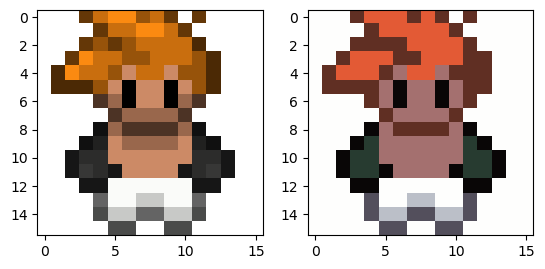

['a pixelated, pixel-art image of a creature with brown shirt, blue and white pants, dense teal blue hair',
 'a pixelated, pixel-art image of a brown character with large blonde hair, a pink shirt and black pants',
 'a pixelated, pixel-art image of A brown character with red shirt, blue pants and white hair with faux bald haircut',
 'a pixelated, pixel-art image of Brown character with black shirt, white pants and golden hair with spikes on right side',
 'a pixelated, pixel-art image of character with long purple hair and gray hat wearing brown shirt and black pants']

In [34]:
rgb_images = images.convert_images_to_rgb(images_oht[:5], rgb_colors)
labels = LABELS[:5]

fig, ax = plt.subplots(1,2)
ax[0].imshow(IMAGES[3])
ax[1].imshow(rgb_images[3])
plt.show()
PRE_PROMPT = 'a pixelated, pixel-art image of '

annotated_labels = [PRE_PROMPT + l for l in labels]
annotated_labels

In [35]:
# Preprocess images and texts
inputs = CLIP_PROCESSOR(text=annotated_labels, images=rgb_images, return_tensors="pt", padding=True)

In [36]:
# Generate embeddings
with torch.no_grad():
    outputs = CLIP_MODEL(**inputs)

# Get image and text embeddings
image_embeddings = outputs.image_embeds
text_embeddings = outputs.text_embeds

In [37]:
import torch.nn.functional as F

similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
print(similarity(image_embeddings, text_embeddings))

tensor([0.3326, 0.3082, 0.3495, 0.3068, 0.3039])
